In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
query_date = dt.datetime.strptime(latest_date , '%Y-%m-%d') - dt.timedelta(days=365)

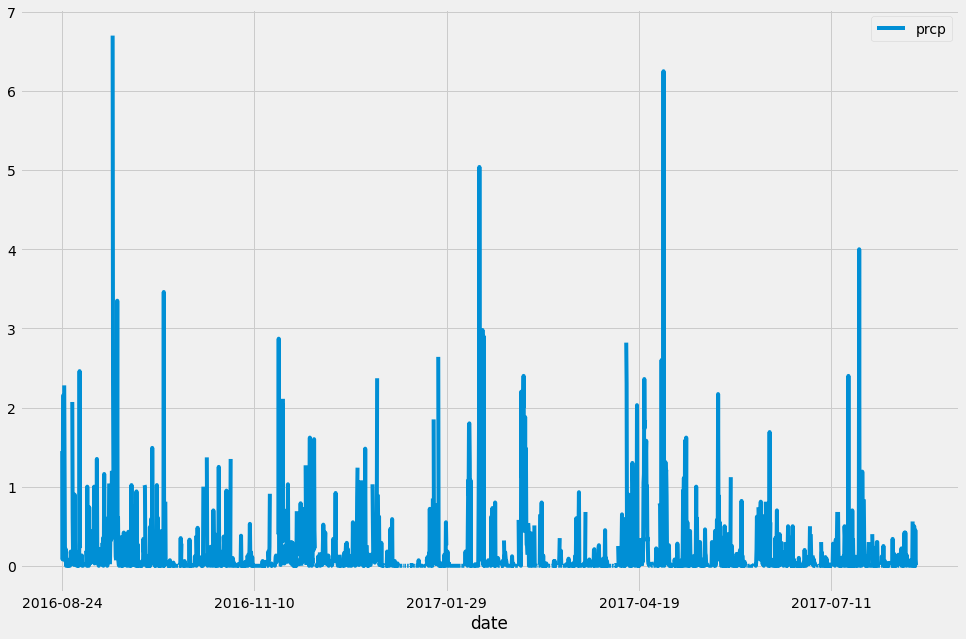

In [20]:
# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(measurement.prcp, measurement.date).\
    filter(measurement.date >= query_date).order_by(measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_data_df = pd.DataFrame(precip_data).set_index('date')

# Sort the dataframe by date
precip_data_df = precip_data_df.sort_values(by='date', ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_data_df.plot.line(figsize = (15,10))
plt.show()

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_data_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [26]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(station.station)).all()


[(9)]

In [32]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [35]:
most_act_station = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).first()[0]

In [41]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

session.query(measurement.station, func.min(measurement.tobs), 
              func.max(measurement.tobs), func.avg(measurement.tobs)).\
    filter(measurement.station == most_act_station).all()


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

Text(0, 0.5, 'Frequency')

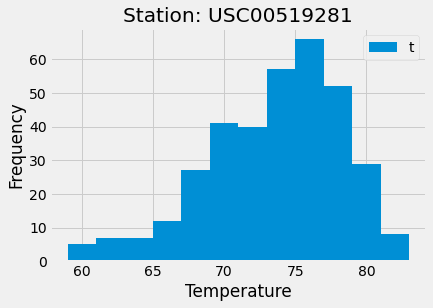

In [65]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_tobs_station = session.query(measurement.station, func.count(measurement.tobs)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.tobs).desc()).first()[0]

tobs_data = session.query(measurement.tobs, measurement.date).\
    filter(measurement.date >= query_date).\
    filter(measurement.station == most_tobs_station).\
    order_by(measurement.date.desc()).all()

tobs_data_df = pd.DataFrame(tobs_data).set_index('date')
tobs_data_df.hist(bins=12)
plt.title(f'Station: {most_tobs_station}')
plt.legend('tobs')
plt.xlabel('Temperature')
plt.ylabel('Frequency')

In [21]:
session.close()

## Bonus Challenge Assignment

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [32]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_start = dt.date(2017, 12, 15) - dt.timedelta(days=365)
trip_end = dt.date(2017, 12, 22) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(trip_start.strftime("%Y-%m-%d"), trip_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)


60.0 71.20754716981132 78.0


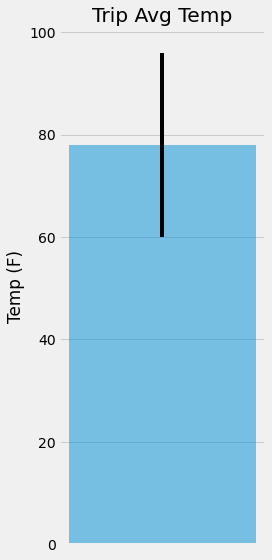

In [33]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


fig, ax = plt.subplots(figsize=plt.figaspect(2.))
x_posit = 1
y_error = tmax-tmin

bar = ax.bar(x_posit, tmax, yerr=y_error, alpha=0.5, align="center")
ax.set(xticks=range(x_posit), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")


# fig.autofmt_xdate()
fig.tight_layout()

In [34]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2016-12-15'
end_date = '2016-12-22'

sel = [station.station, station.name, station.latitude, 
       station.longitude, station.elevation, func.sum(measurement.prcp)]

results = session.query(*sel).\
    filter(measurement.station == station.station).\
    filter(measurement.date >= start_date).\
    filter(measurement.date <= end_date).\
    group_by(station.name).order_by(func.sum(measurement.prcp).desc()).all()
print(results)


[('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 1.97), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 1.4), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.8600000000000001), ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.66), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.25), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.16000000000000003), ('USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9, 0.06)]


In [37]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [39]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start_tobs = '2017-12-15'
trip_end_tobs = '2017-12-22'

# Use the start and end date to create a range of dates
trip_range = pd.date_range(trip_start_tobs, trip_end_tobs, freq='D')


# Strip off the year and save a list of %m-%d strings
trip_month_day = trip_range.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
normals

[(62.0, 71.34, 79.0),
 (60.0, 69.62264150943396, 82.0),
 (63.0, 70.64, 77.0),
 (63.0, 71.28, 77.0),
 (67.0, 72.0, 78.0),
 (65.0, 72.91304347826087, 81.0),
 (67.0, 72.13953488372093, 78.0),
 (67.0, 71.1304347826087, 77.0)]

In [40]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_range_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
trip_range_df['date'] = trip_range
trip_range_df.set_index(['date'],inplace=True)
trip_range_df.head()

,tmin,tavg,tmax
date,,,
2017-12-15,62.0,71.340000,79.0
2017-12-16,60.0,69.622642,82.0
2017-12-17,63.0,70.640000,77.0
2017-12-18,63.0,71.280000,77.0
2017-12-19,67.0,72.000000,78.0


Text(9.310000000000002, 0.5, 'Temperature')

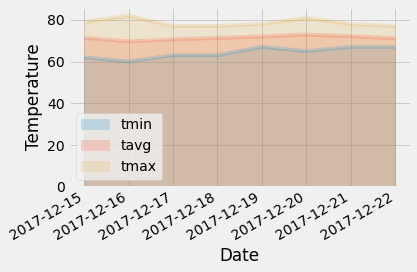

In [41]:
# Plot the daily normals as an area plot with `stacked=False`
trip_range_df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()
plt.xlabel("Date")
plt.ylabel("Temperature")

In [42]:
session.close()